# Run Signal Injection and Recovery process
Inject artificial signals into spectra and run the laser detection algorithm to find the detection threshold.

In [1]:
import astropy.io.fits as fits
import matplotlib.pylab as plt
import numpy as np
from scipy.signal import medfilt
from scipy.interpolate import interp1d
from scipy.interpolate import splev, splrep
import math
from mpmath import mp
import os
import os.path 
import random
from random import seed
from random import choice
from random import uniform
import mplcursors
import pandas as pd
from astropy import stats
%matplotlib inline

## Necessary Functions
First two functions cpied from Anna Zuckerman's Github repository: https://github.com/annazuckerman/specmatch-emp-apf

In [2]:
mp.dps=100
exp_array = np.frompyfunc(mp.exp, 1, 1)

# function to insert simulated gaussians by adding a gaussian into a given location in the spectrum
def insert_gaussian(spectrum, gaussian_params, midpoint, numpoints):
    height = gaussian_params[0]
    position = gaussian_params[1] #position within segment, not index in spectrum
    FWHM = gaussian_params[2]
    offset = gaussian_params[3]
    x = np.linspace(0,numpoints-1,numpoints) # numpoints must be even
    width = FWHM/(2*np.sqrt(2*np.log(2)))    
    gauss = gaussian(x,height,position,width,offset)
    new_spect = spectrum.copy()
    new_spect[midpoint - math.floor(numpoints/2):midpoint + math.floor(numpoints/2)] = new_spect[midpoint - math.floor(numpoints/2):midpoint + math.floor(numpoints/2)] + gauss
    return new_spect

# same as above, but REMOVES the part of the data where the gaussian is inserted
def insert_gaussian_with_data_removal(spectrum, gaussian_params, midpoint, numpoints):
    height = gaussian_params[0]
    position = gaussian_params[1] #position within segment, not index in spectrum
    FWHM = gaussian_params[2]
    offset = gaussian_params[3]
    x = np.linspace(0,numpoints-1,numpoints) # numpoints must be even
    width = FWHM/(2*np.sqrt(2*np.log(2)))    
    gauss = gaussian(x,height,position,width,offset)
    new_spect = spectrum.copy()
    new_spect[midpoint - math.floor(numpoints/2):midpoint + math.floor(numpoints/2)] = gauss
    return new_spect
    
def gaussian(x,a,b,c,d): # a = height, b = position of peak, c = width, x = numpy array of x values
    f = a*exp_array((-(x-b)**2)/(2*c)**2) + d
    return f 

def chi(model, data):
    '''given two arrays of the same length, calculate chi-squared'''
    return np.sum((data - model) ** 2)

## Set parameters

In [3]:
plot = True  # plot each spectra
plot_intermediates = True # plot all individual detections
save_figs = False  # save figures into folders
save_all_signals = False # save a plot of each individual detection

inject_signals = True  # randomly inject signals into data that do not overlap
num_random_injections = 5  # number of injected signals for each spectrum

# for establishing threshold: T = m * n, where m is the median of the medians of pixels that exceed the continuum
n = 60

threshold_testing = True   # plot the detection threshold plot - visualize which heights and widths go detected

plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams.update({'font.size': 19})
plt.rcParams. update({'font.family':'serif'}) 

# table containing all the stars and detections
column_names = ['star', 'index', 'ndetections']
total_detections = pd.DataFrame(columns = column_names)

seed = 2 # random seed to use - using the same seed and keeping all other parameters 
# the same should generate the exact same results each time

In [4]:
# create Laser Detection Results folder
if save_figs or save_all_signals:
    path = '/mnt_home/zoek/code/APF-BL-DAP/Zoe/SignalInjectionRecoveryResults/'
    if not (os.path.isdir(path)):
        os.mkdir(path)

## Read in Reduced Data from Anna Zuckerman's repo

In [5]:
directory = '/mnt_home/azuckerman/BL_APF_DAP/APF_spectra/NDRR_all_apf'

# every file in Anna's NDR_corrected_wl_scale folder
list_of_files = []
for filename in os.listdir(directory):
    if filename.endswith(".fits"): 
        file_path = os.path.join(directory, filename)
        list_of_files = np.append(list_of_files, file_path)

In [6]:
if threshold_testing == True:
    # injected signals information
    heights = []
    indicies = []
    widths = []
    max_flux_vals = []
    
    unrecovered_widths = []
    unrecovered_max_flux_vals = []
    
    # unrecovered signals that failed the width or gaussian test
    failed_unrecovered_widths = []
    failed_unrecovered_indicies = []
    failed_unrecovered_max_flux_vals = []
    
    # recovered signals information
    recovered_widths = []
    recovered_indicies = []
    recovered_max_flux_vals = []
    
    # uninjected detected signals information
    detected_widths = []
    detected_indicies = []
    detected_max_flux_vals = []
    
    star_indicies = [] # which star in the list the other values correspond to
    threshold_vals = []
    
    num_injections = 0
    num_injections_above_threshold = 0
    num_recoveries = 0

In [7]:
all_chi_squared_vals = []

In [8]:
APF_flux_path = list_of_files[2]
file = fits.open(APF_flux_path)
residuals = file[1].data
wl = file[2].data

header = file[0].header
star = header['OBJECT']
print('Star: ' + star)


spect = residuals

Star: TIC158025009


0.5487654582848606 5 0.7285043732273784 10
3.003940462073112 5 0.26954136420943403 10
1.5861630708389995 5 1.4452216411244563 10
3.7347562473775744 5 1.5924351954757363 10


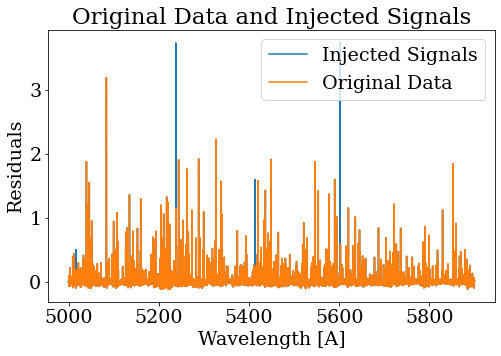

In [9]:
# inject random signals with no overlap
interval = len(spect) / num_random_injections
for i in np.arange(interval, len(spect), interval):

    random.seed(seed)
    random_val = random.choice(residuals[int(i - interval + 30):int(i - 30)])
    location = residuals.tolist().index(random_val)
    height = uniform(0.1, 5)
    width = uniform(0.01, 2)   
    seed += 1

    if width > 8:
        position = 15
        numpoints = 30
    elif width > 5:
        position = 10
        numpoints = 20
    else:
        position = 5
        numpoints = 10

    # create a copy of the spectra to insert PERFECT gaussians instead of adding the gaussians into the data
    # in order to calculate the pixel width of each inserted gaussian 
    copy_of_spect = spect[:]
    print(height, position, width, numpoints)
    copy_of_spect = insert_gaussian_with_data_removal(copy_of_spect, [height, position, width, 0], location, numpoints)

    spect = insert_gaussian(spect,[height, position, width, 0], location, numpoints)


    # find maximum flux value of the inserted signal
    flux_vals = spect[location - int(numpoints / 2) : location + int(numpoints / 2)]
    max_flux_val = max(flux_vals)


if (plot == True) or (save_figs == True):
    fig = plt.figure()
    if inject_signals == True: 
        plt.plot(wl, spect, label = 'Injected Signals')
#         plt.axhline(y=T, color='gray', linestyle='--')
        plt.title('Original Data and Injected Signals')
    else:
        plt.title('Original Data')
        global_median = np.median(residuals)
        global_SD = np.std(residuals)
    plt.plot(wl, residuals, label = 'Original Data')
#     plt.axhline(y=T, color='gray', linestyle='--')
    plt.xlabel('Wavelength [A]')
    plt.ylabel('Residuals')
    plt.legend()
if plot == True:
    plt.show()

In [10]:
# for which_star in np.array([2]):

# # for which_star in random.sample(np.arange(len(list_of_files)).tolist(), 50):
    
#     coordinates = []
#     # the coordinates of every injection
    
#     if threshold_testing == True:
#     # injected signals information
#         temp_widths = []
#         temp_heights = []
#         temp_indicies = []
#         temp_max_flux_vals = []

#         # unrecovered signals information
#         temp_unrecovered_heights = []
#         temp_unrecovered_widths = []
#         temp_unrecovered_indicies = []
#         temp_unrecovered_wavelengths = []
#         temp_unrecovered_max_flux_vals = []

#         # unrecovered signals that failed the width or gaussian test
#         failed_unrecovered_heights = []
#         failed_unrecovered_widths = []
#         failed_unrecovered_indicies = []
#         failed_unrecovered_wavelengths = []
#         failed_unrecovered_max_flux_vals = []

#         # recovered signals information
#         temp_recovered_widths = []
#         temp_recovered_heights = []
#         temp_recovered_indicies = [] # only one needed
#         temp_recovered_wavelengths = []
#         temp_recovered_max_flux_vals = []

#         # uninjected detected signals information
#         detected_widths = []
#         detected_heights = []
#         detected_indicies = []
#         detected_wavelengths = []
#         detected_max_flux_vals = []

    

#     # Take one star from list of all stars
    
    
    
    
        
#     APF_flux_path = list_of_files[which_star]

#     file = fits.open(APF_flux_path)

#     flux = file[0].data
#     residuals = file[1].data
#     wl = file[2].data

#     header = file[0].header
#     star = header['OBJECT']
#     print('Star: ' + star)
    
    
    
    
    
    
#     num_detections_this_star = 0
#     # table containing info about this observation
#     column_names = ['description', 'indicies']
#     detections = pd.DataFrame(columns = column_names)

#     spect = residuals

#     if inject_signals == True:

#         # inject random signals with no overlap
#         interval = len(spect) / num_random_injections
#         for i in np.arange(interval, len(spect), interval):

#             random.seed(seed)
#             random_val = random.choice(flux[int(i - interval + 30):int(i - 30)])
#             location = flux.tolist().index(random_val)
#             height = uniform(0.1, 0.2)
#             width = uniform(0.01, 2)   
#             seed += 1

#             if width > 8:
#                 position = 15
#                 numpoints = 30
#             elif width > 5:
#                 position = 10
#                 numpoints = 20
#             else:
#                 position = 5
#                 numpoints = 10
            
#             star_indicies = np.append(star_indicies, which_star)
#             num_injections += 1

#             # create a copy of the spectra to insert PERFECT gaussians instead of adding the gaussians into the data
#             # in order to calculate the pixel width of each inserted gaussian 
#             copy_of_spect = spect[:]
#             copy_of_spect = insert_gaussian_with_data_removal(copy_of_spect, [height, position, width, 0], location, numpoints)

#             spect = insert_gaussian(spect,[height, position, width, 0], location, numpoints)
#             heights = np.append(heights, height)
#             temp_heights = np.append(temp_heights, height)

#             # find maximum flux value of the inserted signal
#             flux_vals = spect[location - int(numpoints / 2) : location + int(numpoints / 2)]
#             max_flux_val = max(flux_vals)
#             max_flux_vals = np.append(max_flux_vals, max_flux_val)
#             temp_max_flux_vals = np.append(temp_max_flux_vals, max_flux_val)


#             # find width of gaussian in pixels

#             x = wl[location - int(numpoints / 2) : location + int(numpoints / 2)]
            
#             coords = [wl[location - int(numpoints / 2)], wl[location + int(numpoints / 2)]]
#             coordinates = coordinates + [coords]
            
#             y = copy_of_spect[location - int(numpoints / 2) : location + int(numpoints / 2)]
#             y_actual = spect[location - int(numpoints / 2) : location + int(numpoints / 2)]

#             oversampled_x = np.linspace(x[0], x[-1], len(x) * 1000)
#             spl = splrep(x, y)
#             oversampled_y = splev(oversampled_x, spl)
            

#             peak = max(oversampled_y)
#             half_max = peak - height / 2

#             peak_index = oversampled_y.tolist().index(peak)
#             temp_left_bound = peak_index
#             temp_right_bound = peak_index

#             while oversampled_y[temp_left_bound] > half_max and temp_left_bound > 0:
#                 temp_left_bound -=1

#             while oversampled_y[temp_right_bound] > half_max and temp_right_bound < len(oversampled_y) - 1:
#                 temp_right_bound += 1

#             pixel_width = (temp_right_bound - temp_left_bound) / 1000

#             widths = np.append(widths, pixel_width)
#             indicies = np.append(indicies, location)
            
#             temp_widths = np.append(temp_widths, pixel_width)
#             temp_indicies = np.append(temp_indicies, location)

#     temp_unrecovered_widths= temp_widths
#     temp_unrecovered_max_flux_vals = temp_max_flux_vals
        
#     # run laser detection algorithm
#     idxs1 = [] # indicies that are above continuum level
#     idxs2 = [] # indicies in idxs1 that are above the threshold value and are local maximas
#     idxs3 = [] # indicies in idxs2 that are gaussian-shaped
#     idxs4 = [] # indicies in idxs3 that are greater than 5 pixels in width

#     continuum = np.percentile(spect, 95)

#     for idx in np.arange(len(spect)):
#         # first test: create an array of all indices that are above the continuum level
#         if spect[idx] > continuum:
#             idxs1 = idxs1 + [idx]
        

#     consecutive_indicies = []
#     i = 0
#     while i < (len(idxs1) - 1):
#         list = [idxs1[i]]
#         while i < len(idxs1) - 1 and idxs1[i + 1] == idxs1[i] + 1:
#             list = np.append(list, idxs1[i+1])
#             i += 1
#         consecutive_indicies = consecutive_indicies + [list]
#         i +=1

#     median_flux_vals = []
#     for idxs in consecutive_indicies:
#         flux_vals = []
#         for idx in idxs:
#             flux_vals = np.append(flux_vals, spect[idx])
#         median_flux = np.median(flux_vals)
#         median_flux_vals = np.append(median_flux_vals, median_flux)

#     m = np.median(median_flux_vals)


#     T = m * n
#     threshold_vals = np.append(threshold_vals, T)
    
    
    
#     if (plot == True) or (save_figs == True):
#         fig = plt.figure()
#         if inject_signals == True: 
#             plt.plot(wl, spect, label = 'Injected Signals')
#             plt.axhline(y=T, color='gray', linestyle='--')
#             plt.title('Original Data and Injected Signals')
#         else:
#             plt.title('Original Data')
#             global_median = np.median(flux)
#             global_SD = np.std(flux)
#         plt.plot(wl, flux, label = 'Original Data')
#         plt.axhline(y=T, color='gray', linestyle='--')
#         plt.xlabel('Wavelength [A]')
#         plt.ylabel('Flux')
#         plt.legend()
#     if plot == True:
#         plt.show()
        
    
#     for idx in np.arange(len(spect)):
#         if spect[idx] > T:
#             idxs2 = idxs2 + [idx]
            
#     consecutive_indicies_idxs2 = []
#     i = 0
#     while i < (len(idxs2)):
#         list = [idxs2[i]]
#         while (i < len(idxs2) - 1) and (idxs2[i + 1] == idxs2[i] + 1):
#             list = np.append(list, idxs2[i+1])
#             i += 1
#         consecutive_indicies_idxs2 = consecutive_indicies_idxs2 + [list]
#         i +=1

#     median_indicies = []
#     for idxs in consecutive_indicies_idxs2:
#         max_index = max(idxs, key=lambda i: spect[i])
#         median_indicies = np.append(median_indicies, int(max_index))

#     idxs2 = np.array(median_indicies, dtype=int)
#     num_injections_above_threshold += len(idxs2)
    
#     for idx in idxs2:
#         # fit a gaussian to the peak, see if the width is greater than or equal to 2 pixels
#         # see how much signal resembles a gaussian
#         # if last test is commented out, ALSO check FWHM of gaussian

#         # DETERMINING EDGES OF SIGNAL: mark edge when flux reaches a local minimum
#         # PRO: can identify two signals together
#         # CON: can't deal with noise in signal

#         temp_ind = idx
#         left_bound = 0
#         while temp_ind > 1:
#             temp_ind -= 1
#             if spect[temp_ind] < spect[temp_ind - 1] and spect[temp_ind] < spect[temp_ind + 1]:
#                 left_bound = temp_ind
#                 break
#         temp_ind = idx
#         right_bound = len(spect) - 1
#         while temp_ind < len(spect) - 4:
#             temp_ind += 1
#             if (spect[temp_ind] < spect[temp_ind - 1]) and (spect[temp_ind] < spect[temp_ind + 1]):
#                 right_bound = temp_ind
#                 break

#         x = wl[left_bound:right_bound + 2]
#         y = spect[left_bound:right_bound + 2]

#         # oversample detected signal to determine precise bounds on the edges of the signal
#         # use this to determine the FWHM of the signal in pixels
#         oversampled_x = np.linspace(x[0], x[-1], len(x) * 10)
#         spl = splrep(x, y)
#         oversampled_y = splev(oversampled_x, spl)

#         max_y = max(oversampled_y)
#         min_y = np.percentile(oversampled_y, 3) 
#         height = max_y - min_y
#         ind = oversampled_y.tolist().index(max_y)
#         pos = oversampled_x[ind]
#         min_width = 0.00001
#         max_width = oversampled_x[len(oversampled_x) - 1] - oversampled_x[0]
#         width_spacing = 0.001

#         chi_squared_values = []
#         width_vals = np.arange(min_width, max_width, width_spacing)
#         for w in width_vals:
#             gaus = gaussian(oversampled_x, height, pos, w, min_y)
#             chi_squared = chi(gaus, oversampled_y)
#             chi_squared_values = np.append(chi_squared_values, chi_squared)
#         min_chi_squared = min(chi_squared_values)
#         ind_of_min_chisquared = chi_squared_values.tolist().index(min_chi_squared)
#         width = width_vals[ind_of_min_chisquared]
#         gaus = gaussian(oversampled_x, height, pos, width, min_y)

#         width_threshold = False
#         gauss_threshold = False

#         # see if the signal fits a gaussian
#         if min_chi_squared < 100000:
#             gauss_threshold = True
#             idxs3 = idxs3 + [idx]

#             # find the width of the gaussian in pixels

#             peak = max(gaus)
#             half_max = peak - height / 2

#             peak_index = gaus.tolist().index(peak)
#             temp_left_bound = peak_index
#             temp_right_bound = peak_index

#             while gaus[temp_left_bound] > half_max and temp_left_bound > 0:
#                 temp_left_bound -=1

#             while gaus[temp_right_bound] > half_max and temp_right_bound < len(gaus) - 1:
#                 temp_right_bound += 1

#             pixel_width = (temp_right_bound - temp_left_bound) / 10

#             if pixel_width > 2.7:
#                 width_threshold = True
#                 idxs4 = idxs4 + [idx]
#                 num_detections_this_star += 1
#                 index = 'none'
                
#                 detection_was_injected = False
#                 indicies_recovered = []
#                 for i in np.arange(len(coordinates)):
#                     coord = coordinates[i]
#                     wl_min = coord[0]
#                     wl_max = coord[1]
#                     if wl_min < wl[idx] < wl_max:
#                         detection_was_injected = True
#                         indicies_recovered + [i]
#                         coordinates.remove(coordinates[i])
#                         temp_unrecovered_widths = np.delete(temp_unrecovered_widths, i)
#                         temp_unrecovered_max_flux_vals = np.delete(temp_unrecovered_max_flux_vals, i)
#                         break
                        
                
#                 if detection_was_injected:
#                     all_chi_squared_vals = all_chi_squared_vals + [float(min_chi_squared)]
#                     index = idx
#                     temp_recovered_indicies = np.append(temp_recovered_indicies, temp_indicies[i])
#                     temp_recovered_widths = np.append(temp_recovered_widths, pixel_width)
#                     temp_recovered_max_flux_vals = np.append(temp_recovered_max_flux_vals, max(y))

#                     if plot_intermediates:
#                         plt.plot(oversampled_x, gaus)
#                         plt.step(x, y)
#                         plt.xlabel('Wavelength')
#                         plt.ylabel('Flux')
#                         plt.title('Recovered Injection')
#                         plt.show()
# #                 else:
# #                     detected_indicies = np.append(detected_indicies, index)
# #                     detected_widths = np.append(detected_widths, pixel_width)
# #                     detected_max_flux_vals = np.append(detected_max_flux_vals, max(y))
# #                     if plot_intermediates:
# #                         plt.plot(oversampled_x, gaus)
# #                         plt.plot(x, y)
# #                         plt.xlabel('Wavelength')
# #                         plt.ylabel('Flux')
# #                         plt.title('Detected Injection')
# #                         plt.show()
                        
                        
#             else:
#                 failed_unrecovered_indicies = failed_unrecovered_indicies + [idx]
#                 failed_unrecovered_widths = failed_unrecovered_widths + [pixel_width]
#                 failed_unrecovered_max_flux_vals = failed_unrecovered_max_flux_vals + [max(y)]
#         else:
#             failed_unrecovered_indicies = failed_unrecovered_indicies + [idx]
            
    
#     unrecovered_widths = unrecovered_widths + temp_unrecovered_widths.tolist()
#     unrecovered_max_flux_vals = unrecovered_max_flux_vals + temp_unrecovered_max_flux_vals.tolist()
    
#     if len(temp_recovered_widths) > 0:
#         recovered_widths = recovered_widths + temp_recovered_widths.tolist()
#     if len(temp_recovered_max_flux_vals) > 0:
#         recovered_max_flux_vals = recovered_max_flux_vals + temp_recovered_max_flux_vals.tolist()

# #     for i in np.arange(len(coordinates)):
# #         coord = coordinates[i]
# #         wl_min = coord[0]
# #         wl_max = coord[1]
        
# #     print('idxs4: ' + str(idxs4))